# Global Imports

In [63]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
from collections import Counter
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence

random.seed(42)

# Local Imports

In [64]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.word_dataset import WordImageDataset
from models.allcnn2d import AllCNN2D
from models.allcnn2d_rnn import CNNRNNModel

# Globals

In [65]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "KrudRNN"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\Krud_epoch29_trainacc0.93466_valacc0.97159_Tloss0.013132_Vloss0.0056677_lr0.0007224.pkl"

# Define Paths
Workspace

In [66]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [67]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-f]+)[-]+([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)

len(image_paths)

1286

# Helper Functions

In [68]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [69]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels From File Names

In [70]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)[1:]
    
    char: str = chr(int(u_hexvalue, base=16))
    
    
    class_counts[char] += 1
    
    
    labeled_image_paths.append((char, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))

len(labels), len(image_paths)

(1286, 1286)

In [71]:
Counter(labels)

Counter({'+': 54,
         'a': 54,
         '1': 54,
         '.': 49,
         'λ': 49,
         '(': 48,
         ')': 48,
         ':': 29,
         '<': 24,
         '-': 23,
         '÷': 23,
         '×': 22,
         ']': 22,
         '>': 22,
         '=': 22,
         '[': 22,
         '}': 21,
         '8': 20,
         'c': 20,
         'p': 20,
         's': 20,
         '5': 20,
         'v': 20,
         'f': 20,
         '6': 20,
         'i': 20,
         'o': 20,
         'y': 20,
         '4': 20,
         'z': 20,
         '2': 20,
         'x': 20,
         'm': 20,
         'e': 20,
         'w': 20,
         't': 20,
         'd': 20,
         'b': 20,
         'g': 20,
         '{': 20,
         'j': 20,
         '7': 20,
         'k': 20,
         'q': 20,
         '0': 20,
         'h': 20,
         'l': 20,
         'u': 20,
         '3': 20,
         'n': 20,
         '9': 20,
         'r': 20})

# Balance Classes Using Oversample/Undersample

In [72]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)
min_count: int = min(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count 
    for uid, count in 
    sorted_counts
}

to_undersample_counts: dict[str, int] = {
    uid: min_count
    for uid, count in 
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)


In [73]:
min_count, max_count, total_items

(20, 54, 1286)

In [74]:
#print(*to_add_counts.items())
#print(sorted([(chr(int(pair[0][1:], 16)), pair[1]) for pair in to_remove_counts.items()], key=lambda x: x[1]))

# Oversample

In [75]:
#to_add_labels: list[str] = []
#to_add_file_paths: list[str] = []
#
#while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:  
#    for label, image_path in zip(labels, image_paths):
#        remaining: int = to_add_counts[label]
#        
#        if remaining > 0:
#            to_add_labels.append(label)
#            to_add_file_paths.append(image_path)
#            to_add_counts[label] -= 1

# Undersample

In [76]:
to_keep_labels: list[str] = []
to_keep_file_paths: list[str] = []

while True in [to_add_count>0 for to_add_count in to_undersample_counts.values()]:  
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_undersample_counts[label]
        
        if remaining > 0:
            to_keep_labels.append(label)
            to_keep_file_paths.append(image_path)
            to_undersample_counts[label] -= 1

In [77]:
to_keep_labels

['8',
 'c',
 'p',
 's',
 's',
 '5',
 'v',
 '×',
 'f',
 '6',
 '8',
 'i',
 'v',
 '+',
 'o',
 'y',
 '4',
 '(',
 'z',
 '2',
 'x',
 'm',
 '+',
 '-',
 'e',
 's',
 'w',
 '×',
 't',
 'd',
 ']',
 's',
 'o',
 '.',
 'b',
 'o',
 'g',
 'o',
 ')',
 'd',
 'c',
 'λ',
 'a',
 '{',
 '<',
 'y',
 'λ',
 'a',
 '+',
 'j',
 'v',
 '2',
 '.',
 'd',
 '>',
 '6',
 't',
 't',
 'c',
 'm',
 'i',
 'p',
 'm',
 ')',
 '(',
 'g',
 '(',
 'b',
 '7',
 'k',
 '÷',
 'p',
 'e',
 '.',
 ')',
 'p',
 '>',
 '}',
 'e',
 '÷',
 'm',
 'w',
 '(',
 ')',
 '1',
 'q',
 '0',
 'q',
 'x',
 'g',
 'i',
 'e',
 'h',
 't',
 'i',
 'l',
 'b',
 'y',
 'λ',
 'i',
 'x',
 '0',
 '+',
 ':',
 '.',
 ')',
 'x',
 '(',
 '(',
 'l',
 'd',
 '1',
 'h',
 'j',
 'u',
 '3',
 '1',
 ')',
 'n',
 '1',
 '.',
 'p',
 'h',
 'x',
 'λ',
 'q',
 '>',
 '.',
 'a',
 ':',
 'v',
 'a',
 'g',
 '0',
 's',
 ')',
 '9',
 ']',
 'λ',
 ':',
 'k',
 '=',
 'c',
 '>',
 '-',
 '2',
 ']',
 'p',
 'm',
 'c',
 '>',
 'y',
 '0',
 'w',
 '1',
 'u',
 'p',
 'm',
 '+',
 'b',
 '3',
 'b',
 '{',
 '(',
 'k',
 '+',
 'r'

In [78]:

Counter(to_keep_labels), sorted(list(set(to_keep_labels)))

(Counter({'8': 20,
          'c': 20,
          'p': 20,
          's': 20,
          '5': 20,
          'v': 20,
          '×': 20,
          'f': 20,
          '6': 20,
          'i': 20,
          '+': 20,
          'o': 20,
          'y': 20,
          '4': 20,
          '(': 20,
          'z': 20,
          '2': 20,
          'x': 20,
          'm': 20,
          '-': 20,
          'e': 20,
          'w': 20,
          't': 20,
          'd': 20,
          ']': 20,
          '.': 20,
          'b': 20,
          'g': 20,
          ')': 20,
          'λ': 20,
          'a': 20,
          '{': 20,
          '<': 20,
          'j': 20,
          '>': 20,
          '7': 20,
          'k': 20,
          '÷': 20,
          '}': 20,
          '1': 20,
          'q': 20,
          '0': 20,
          'h': 20,
          'l': 20,
          ':': 20,
          'u': 20,
          '3': 20,
          'n': 20,
          '9': 20,
          '=': 20,
          'r': 20,
          '[': 20}),
 ['(',
  '

# Load Dataset

In [79]:
image_paths = to_keep_file_paths
labels = to_keep_labels
len(image_paths), len(labels)

(1040, 1040)

In [80]:
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_split(file_paths, labels, test_size=0.15, val_size=0.15, min_samples=1, random_state=42):
    """
    Stratified split with minimum samples per class in all splits
    
    Args:
        file_paths: List of lists of paths - [[class1_paths], [class2_paths], ...]
        labels: List of class labels corresponding to file_paths
        test_size: Proportion for test split
        val_size: Proportion for validation split (relative to remaining after test)
        min_samples: Minimum samples per class in each split (default=1)
    """
    # Flatten structure and create label array
    
    # Convert to numpy arrays
    X = np.array(file_paths)
    y = np.array(labels)
    unique_classes = np.unique(y)
    
    # First split: test with min samples per class
    test_indices = []
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        n_test = max(min_samples, int(test_size * len(cls_indices)))
        test_indices.extend(np.random.choice(cls_indices, n_test, replace=False))
    
    # Remaining indices for train/val
    remaining_mask = ~np.isin(np.arange(len(X)), test_indices)
    X_remaining, y_remaining = X[remaining_mask], y[remaining_mask]
    
    # Second split: validation from remaining
    val_indices = []
    for cls in unique_classes:
        cls_indices = np.where(y_remaining == cls)[0]
        n_val = max(min_samples, int(val_size * len(cls_indices)))
        val_indices.extend(np.random.choice(cls_indices, n_val, replace=False))
    
    # Final indices
    train_mask = ~np.isin(np.arange(len(X_remaining)), val_indices)
    return (
        X_remaining[train_mask].tolist(), y_remaining[train_mask].tolist(),  # Train
        X_remaining[val_indices].tolist(), y_remaining[val_indices].tolist(),  # Val
        X[test_indices].tolist(), y[test_indices].tolist()  # Test
    )



In [81]:



train_x, train_y, val_x, val_y, test_x, test_y = stratified_split(image_paths, labels)

print(f"Train ({len(train_x)}): {train_x} {train_y}")
print(f"Val   ({len(val_x)}): {val_x} {val_y}")
print(f"Test  ({len(test_x)}): {test_x} {test_y}")

Train (780): ['c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u38-1737059278788.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u63-1737059641321.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u70-1737059657139.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u73-1737713959686.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u76-1737715357236.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\ud7-1737059851111.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u66-1737714100430.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\

In [82]:
all_label_classes = [
    '(',
    ')',
    '+',
    '-',
    '.',
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9',
    ':',
    '<',
    '=',
    '>',
    '[',
    ']',
    'a',
    'b',
    'c',
    'd',
    'e',
    'f',
    'g',
    'h',
    'i',
    'j',
    'k',
    'l',
    'm',
    'n',
    'o',
    'p',
    'q',
    'r',
    's',
    't',
    'u',
    'v',
    'w',
    'x',
    'y',
    'z',
    '{',
    '}',
    '×',
    '÷',
    'λ'
]


# Get valid words

In [ ]:
import pandas as pd
valid_words = pd.read_csv("metadata-lambda.csv")["line"].to_list()

num_words = len(valid_words)

train_words = valid_words[:int(num_words*0.8)]
val_words = valid_words[int(num_words*0.8):]


# Load Dataloaders

In [ ]:

train_char_dataset: WordImageDataset = WordImageDataset(
    words=train_words,
    file_paths=train_x, #list(image_paths[:split_index]) + to_add_file_paths,
    labels=train_y, #list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.05,
    translation_limit=0.2,
    skew_limit=0.02,
    zoom_change=1.2,
    min_zoom=0.8,
    thicken_sigma=-4.9,
    image_dims=(64, 64)
)

val_char_dataset: WordImageDataset = WordImageDataset(
    words=val_words,
    file_paths=val_x,
    labels=val_y,
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=0.0,
    image_dims=(64, 64)
)




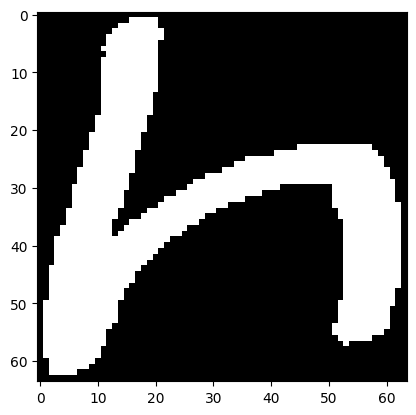

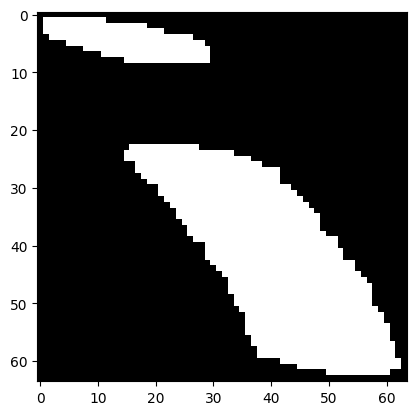

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


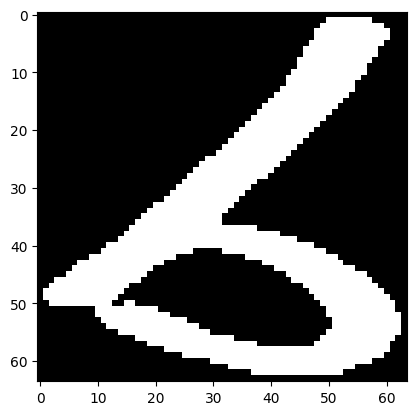

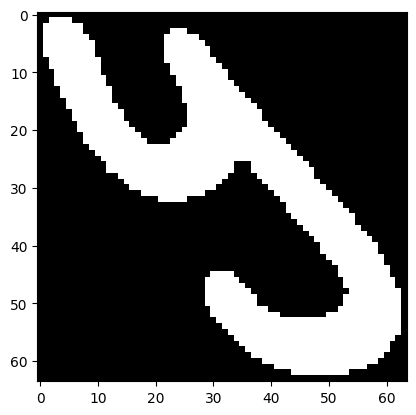

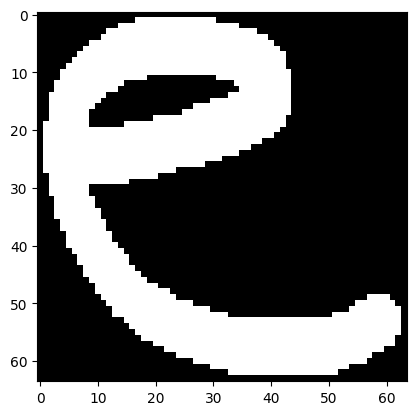

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [85]:
for im, lab in train_char_dataset:
    
    for letter in im:
    
        plt.imshow(
            rearrange(letter, "1 h w -> h w")*255, 
            cmap="gray"
        )
        plt.show()
    
    print(lab)
    

# Load DataLoader

In [25]:
def collate_fn(batch):
    """
    Collate function to pad sequences to the same length.
    """
    # Separate images and labels
    images, labels = zip(*batch)

    # Pad image sequences
    images_padded = pad_sequence(images, batch_first=True, padding_value=0.0)

    # Pad label sequences
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0.0)

    return images_padded, labels_padded

train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16,
    collate_fn=collate_fn
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16,
    collate_fn=collate_fn
)

In [37]:
sorted(class_counts.keys()), len(sorted(class_counts.keys()))

(['(',
  ')',
  '+',
  '-',
  '.',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  ':',
  '<',
  '=',
  '>',
  '[',
  ']',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  '{',
  '}',
  '×',
  '÷',
  'λ'],
 52)

# Prepare Pretrained CNN Encoder

In [39]:



cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 256), 
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT,
        "use_lora": False,
        "lora_config": {"rank": 1, "alpha": 1.0}
    }
)


Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

In [40]:

# List of layers to remove
layers_to_remove = [
    'fully_connected_blocks.0.0.weight',
    'fully_connected_blocks.0.0.bias',
    'fully_connected_blocks.1.0.weight',
    'fully_connected_blocks.1.0.bias'
]

# Reconstruct the fully_connected_blocks without the removed layers
new_fully_connected_blocks = nn.ModuleList()

for block in cnn_model.fully_connected_blocks:
    new_block = nn.Sequential()
    for layer in block:
        # Skip layers that were removed
        if not any(layer_name in str(layer) for layer_name in layers_to_remove):
            new_block.append(layer)
    new_fully_connected_blocks.append(new_block)

# Replace the old fully_connected_blocks with the new one
cnn_model.fully_connected_blocks = new_fully_connected_blocks

for name, param in cnn_model.named_parameters():
    param.requires_grad = False

summary(cnn_model)



Layer (type:depth-idx)                   Param #
AllCNN2D                                 --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (160)
│    │    └─Dropout2d: 3-2               --
│    │    └─BatchNorm2d: 3-3             (32)
│    │    └─LeakyReLU: 3-4               --
│    │    └─Conv2d: 3-5                  (2,320)
│    │    └─Dropout2d: 3-6               --
│    │    └─BatchNorm2d: 3-7             (32)
│    │    └─LeakyReLU: 3-8               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-9                  (4,640)
│    │    └─Dropout2d: 3-10              --
│    │    └─BatchNorm2d: 3-11            (64)
│    │    └─LeakyReLU: 3-12              --
│    │    └─Conv2d: 3-13                 (9,248)
│    │    └─Dropout2d: 3-14              --
│    │    └─BatchNorm2d: 3-15            (64)
│    │    └─LeakyReLU: 3-16              --
│    └─Sequential: 2-3                   --
│

# Create RNNCNN

In [41]:
rnn_cnn: CNNRNNModel = CNNRNNModel(
    cnn_encoder=cnn_model,
    rnn_type="rnn",
    num_classes=len(all_label_classes)
)

summary(rnn_cnn)

Layer (type:depth-idx)                   Param #
CNNRNNModel                              --
├─AllCNN2D: 1-1                          --
│    └─ModuleList: 2-1                   --
│    │    └─Sequential: 3-1              (2,544)
│    │    └─Sequential: 3-2              (14,016)
│    │    └─Sequential: 3-3              (18,624)
│    │    └─Sequential: 3-4              (18,624)
│    │    └─Sequential: 3-5              (18,624)
│    └─ModuleList: 2-2                   --
│    │    └─Sequential: 3-6              (8,256)
│    │    └─Sequential: 3-7              (16,640)
│    └─Sequential: 2-3                   --
│    │    └─Flatten: 3-8                 --
├─RNN: 1-2                               66,048
├─Linear: 1-3                            6,708
Total params: 170,084
Trainable params: 72,756
Non-trainable params: 97,328

# Create Optimiser

In [59]:
all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.0007224,
        "weight_decay": 0.000001
    }
]

optim: AdamW = AdamW()

TypeError: AdamW.__init__() missing 1 required positional argument: 'params'

# Train

In [51]:


for X, y in train_dataloader:
    pass

# Inference

In [54]:
cnn_model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,#0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch26_trainacc0.71327_valacc0.99057_Tloss0.072851_Vloss0.0056362_lr0.0007224999999999999.pkl"
    }
)

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 44]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

Layer (type:depth-idx)                   Param #
AllCNN2D                                 --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  160
│    │    └─Dropout2d: 3-2               --
│    │    └─BatchNorm2d: 3-3             32
│    │    └─LeakyReLU: 3-4               --
│    │    └─Conv2d: 3-5                  2,320
│    │    └─Dropout2d: 3-6               --
│    │    └─BatchNorm2d: 3-7             32
│    │    └─LeakyReLU: 3-8               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-9                  4,640
│    │    └─Dropout2d: 3-10              --
│    │    └─BatchNorm2d: 3-11            64
│    │    └─LeakyReLU: 3-12              --
│    │    └─Conv2d: 3-13                 9,248
│    │    └─Dropout2d: 3-14              --
│    │    └─BatchNorm2d: 3-15            64
│    │    └─LeakyReLU: 3-16              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2

In [ ]:
rnncnn_model = CNNRNNModel(
    cnn_encoder=
)

In [ ]:
for char, label in val_char_dataset:
    plt.imshow(char[0, :, :])
    plt.show()
    pred: torch.Tensor = model.forward(char.unsqueeze(0)).squeeze()
    pred_index: int = torch.argmax(pred).item()
    print(chr(int(all_label_classes[pred_index][1:], base=16)))

TypeError: pad() got an unexpected keyword argument 'mode'